# Entwicklung von KI in der Wissenschaft

In [128]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import HuberRegressor

## Helper Functions

In [129]:
def plot_with_trendline(df, title, period):
    df["period"] = df["published_date"].dt.to_period(period)
    papers_per_period = df.groupby("period").size().reset_index(name="count")
    papers_per_period["period"] = papers_per_period["period"].dt.to_timestamp()

    # Create scatter plot with trendline using plotly
    fig = px.scatter(papers_per_period, x="period", y="count", trendline="lowess", title=title + " (Original Scale)")
    fig.update_layout(xaxis_title="Period", yaxis_title="Number of Papers")
    fig.show()

    # Scatter plot with logarithmic scale
    fig_log = px.scatter(papers_per_period, x="period", y="count", trendline="ols", title=title + " (Logarithmic Scale)", log_x=True, log_y=True)
    fig_log.update_layout(xaxis_title="Period", yaxis_title="Number of Papers (Log Scale)")
    fig_log.show()

## Data

In [130]:
df = pd.read_csv("arxiv_papers.csv")
df.head()

,paper_id,published_date,categories,id
0,http://arxiv.org/abs/cs/9401101v1,1994-01-01,cs.AI,9401101v1
1,http://arxiv.org/abs/cs/9403101v1,1994-03-01,cs.AI,9403101v1
2,http://arxiv.org/abs/cs/9402101v1,1994-02-01,cs.AI,9402101v1
3,http://arxiv.org/abs/cs/9402102v1,1994-02-01,cs.AI,9402102v1
4,http://arxiv.org/abs/cs/9402103v1,1994-02-01,cs.AI,9402103v1


These categories can be used in search queries to filter relevant papers.

- cs.LG: Machine Learning
- cs.AI: Artificial Intelligence
- stat.ML: Statistics > Machine Learning
- cs.NE: Neural and Evolutionary Computing
- cs.CL: Computation and Language
- cs.CV: Computer Vision and Pattern Recognition
- cs.RO: Robotics

In [131]:
df["published_date"] = pd.to_datetime(df["published_date"])

# df = df[df["published_date"] < "2022-01-01"]

categories = ["cs.lg", "cs.ai", "stat.ml", "cs.ne", "cs.cl", "cs.cv", "cs.ro"]
df = df[df["categories"].str.lower().str.contains('|'.join(categories))]

## Visualization

### Allgemeine Entwicklung

In [132]:
df = df[df["categories"].str.lower().str.contains('|'.join(categories))]
plot_with_trendline(df, "Number of Papers Published Over Time", "M")

In [133]:
plot_with_trendline(df, "Number of Papers Published Over Time", "Y")

### Nach Kategorien

### Nach 5-Jahres Perioden

In [134]:
period = 5 # in years
df["published_date"] = pd.to_datetime(df["published_date"])
df["period"] = (df["published_date"].dt.year // period) * period
df["period"] = df["period"].astype(str) + " - " + (df["period"] + period - 1).astype(str)
df

,paper_id,published_date,categories,id,period
0,http://arxiv.org/abs/cs/9401101v1,1994-01-01,cs.AI,9401101v1,1990 - 1994
1,http://arxiv.org/abs/cs/9403101v1,1994-03-01,cs.AI,9403101v1,1990 - 1994
2,http://arxiv.org/abs/cs/9402101v1,1994-02-01,cs.AI,9402101v1,1990 - 1994
3,http://arxiv.org/abs/cs/9402102v1,1994-02-01,cs.AI,9402102v1,1990 - 1994
4,http://arxiv.org/abs/cs/9402103v1,1994-02-01,cs.AI,9402103v1,1990 - 1994
...,...,...,...,...,...
408813,http://arxiv.org/abs/2412.04683v1,2024-12-06,cs.AI,2412.04683v1,2020 - 2024
408814,http://arxiv.org/abs/2412.04682v1,2024-12-06,"cs.LG,cs.AI",2412.04682v1,2020 - 2024
408815,http://arxiv.org/abs/2412.04680v1,2024-12-06,cs.CV,2412.04680v1,2020 - 2024
408816,http://arxiv.org/abs/2412.04678v1,2024-12-06,cs.CV,2412.04678v1,2020 - 2024


In [135]:
# Explode the categories column to handle multiple categories per paper.
df['categories'] = df['categories'].str.lower().str.split(';')
df = df.explode('categories')
df['categories'] = df['categories'].str.strip()

# Filter for the categories of interest
df_filtered = df[df['categories'].isin(categories)]

# Create the counts table
counts = df_filtered.groupby(['categories', "period"]).size().unstack(fill_value=0)
display(counts)

# Plot the heatmap
fig_heatmap = px.imshow(counts, labels=dict(x="Period", y="Category", color="Count"), x=counts.columns, y=counts.index, text_auto=True, aspect="auto")
fig_heatmap.update_layout(title="Publication Counts by Period and Category")
fig_heatmap.show()

period,1990 - 1994,1995 - 1999,2000 - 2004,2005 - 2009,2010 - 2014,2015 - 2019,2020 - 2024
categories,,,,,,,
cs.ai,14,81,9,228,2362,2290,4859
cs.cl,0,0,6,98,457,6251,18497
cs.cv,0,0,1,114,1691,17952,41727
cs.lg,0,0,0,117,674,1706,15511
cs.ne,0,0,0,80,331,842,1213
cs.ro,0,0,12,158,319,2697,9988
stat.ml,0,0,0,75,419,978,23


### Nach Jahr

In [136]:
period = 1 # in years
df["period"] = df["published_date"].dt.year
df

,paper_id,published_date,categories,id,period
0,http://arxiv.org/abs/cs/9401101v1,1994-01-01,cs.ai,9401101v1,1994
1,http://arxiv.org/abs/cs/9403101v1,1994-03-01,cs.ai,9403101v1,1994
2,http://arxiv.org/abs/cs/9402101v1,1994-02-01,cs.ai,9402101v1,1994
3,http://arxiv.org/abs/cs/9402102v1,1994-02-01,cs.ai,9402102v1,1994
4,http://arxiv.org/abs/cs/9402103v1,1994-02-01,cs.ai,9402103v1,1994
...,...,...,...,...,...
408813,http://arxiv.org/abs/2412.04683v1,2024-12-06,cs.ai,2412.04683v1,2024
408814,http://arxiv.org/abs/2412.04682v1,2024-12-06,"cs.lg,cs.ai",2412.04682v1,2024
408815,http://arxiv.org/abs/2412.04680v1,2024-12-06,cs.cv,2412.04680v1,2024
408816,http://arxiv.org/abs/2412.04678v1,2024-12-06,cs.cv,2412.04678v1,2024


In [137]:
df['categories'] = df['categories'].str.lower().str.split(';')
df = df.explode('categories')
df['categories'] = df['categories'].str.strip()

# Filter for the categories of interest
df_filtered = df[df['categories'].isin(categories)]

# Create the counts table
counts = df_filtered.groupby(['categories', "period"]).size()
display(counts)

categories  period
cs.ai       1994      14
            1995      26
            1996      28
            1997      18
            1998       9
                      ..
stat.ml     2020       1
            2021       2
            2022       3
            2023      16
            2024       1
Length: 147, dtype: int64

In [138]:
counts = counts.reset_index(name="count")

# Plot the line chart with linear scale using plotly
fig_line = px.line(counts, x='period', y='count', color='categories', markers=True, title="Publication Counts by Period and Category (Linear Scale)")
fig_line.show()

# Plot the line chart with logarithmic scale using plotly
fig_line_log = px.line(counts, x='period', y='count', color='categories', markers=True, title="Publication Counts by Period and Category (Logarithmic Scale)", log_y=True)
fig_line_log.show()

In [139]:
# Plot the heatmap
plt.figure(figsize=(20, 8))  # Adjust figure size for better readability
sns.heatmap(counts, annot=True, fmt="d", cmap="crest")  # Added annotations and colormap
plt.title("Publication Counts by Period and Category")
plt.xlabel("Period")
plt.xticks(rotation=45)  # Rotate x ticks for better readability
plt.ylabel("Category")
plt.yticks(rotation=0) #prevent rotation of y ticks
plt.show()

NameError: name 'sns' is not defined

<Figure size 2000x800 with 0 Axes>

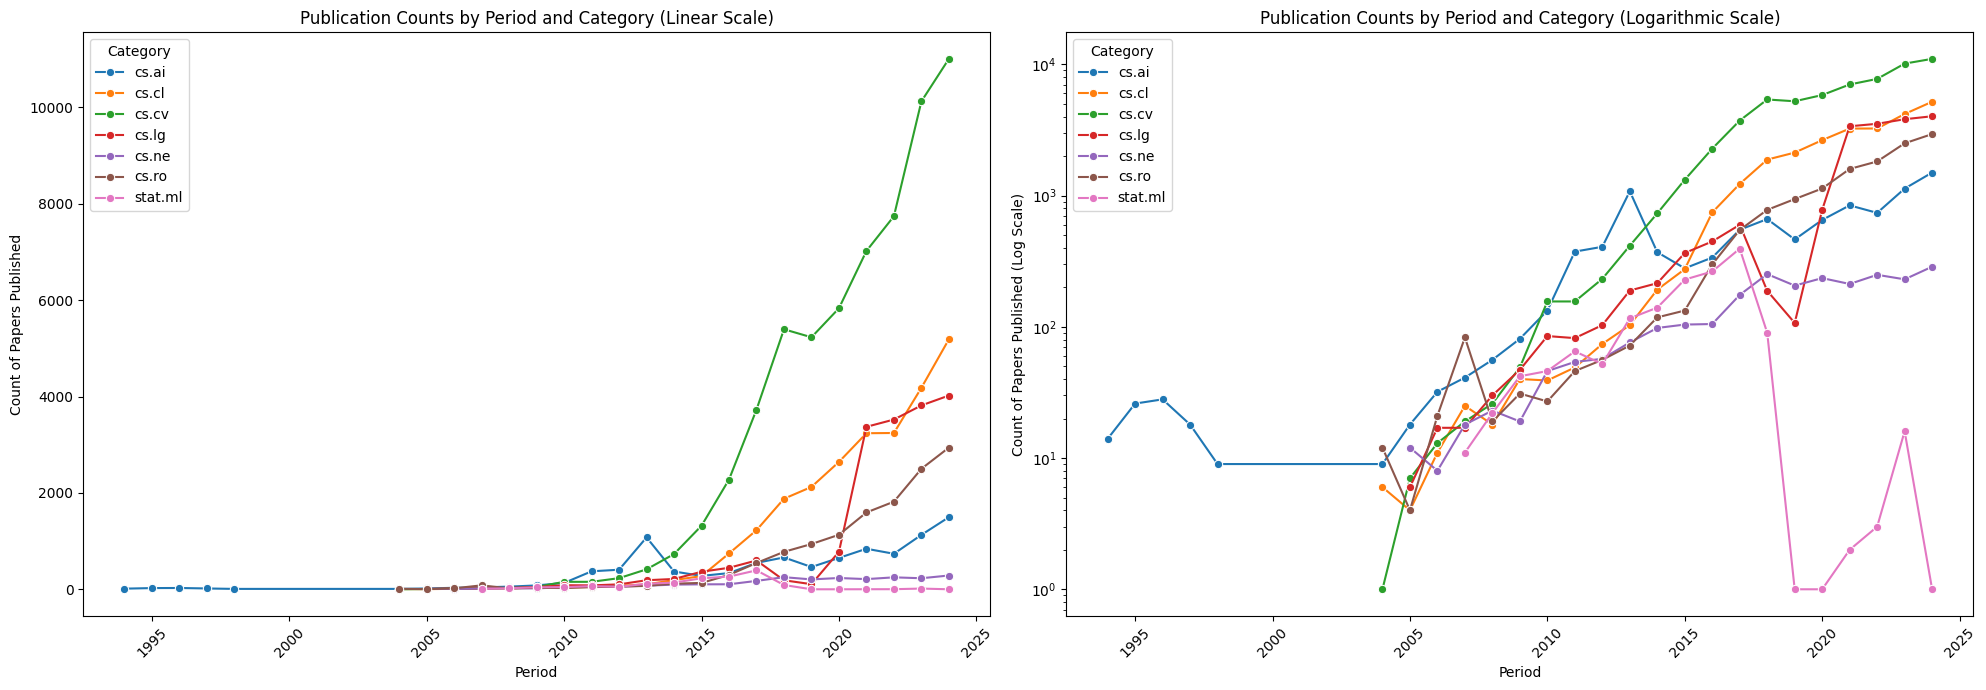

In [ ]:
# Explode the categories column to handle multiple categories per paper.
df['categories'] = df['categories'].str.lower().str.split(';')
df = df.explode('categories')
df['categories'] = df['categories'].str.strip()

# Filter for the categories of interest
df_filtered = df[df['categories'].isin(categories)]

# Create the counts table
counts = df_filtered.groupby(['categories', "period"]).size().reset_index(name='count')

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# Plot the line chart with linear scale
sns.lineplot(data=counts, x='period', y='count', hue='categories', marker='o', ax=ax1)
ax1.set_title("Publication Counts by Period and Category (Linear Scale)")
ax1.set_xlabel("Period")
ax1.set_ylabel("Count of Papers Published")
ax1.legend(title='Category')
ax1.tick_params(axis='x', rotation=45)

# Plot the line chart with logarithmic scale
sns.lineplot(data=counts, x='period', y='count', hue='categories', marker='o', ax=ax2)
ax2.set_yscale('log')
ax2.set_title("Publication Counts by Period and Category (Logarithmic Scale)")
ax2.set_xlabel("Period")
ax2.set_ylabel("Count of Papers Published (Log Scale)")
ax2.legend(title='Category')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()